[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed
Nani?! in data
[[0.14726591 0.00740369 0.28348061 0.90560406]
 [0.16287018 0.00718103 0.23738952 0.93958657]
 [0.15941873 0.00679135 0.2424201  0.91673288]
 ...
 [0.75404546 0.86439547 0.17675049 0.75198726]
 [0.77007934 0.87085282 0.16723317 0.74721776]
 [0.76770556 0.87096412 0.17036029 0.75616054]]


array([[0.12256949],
       [0.12224426],
       [0.12903061],
       ...,
       [0.76521772],
       [0.75404546],
       [0.77007934]])

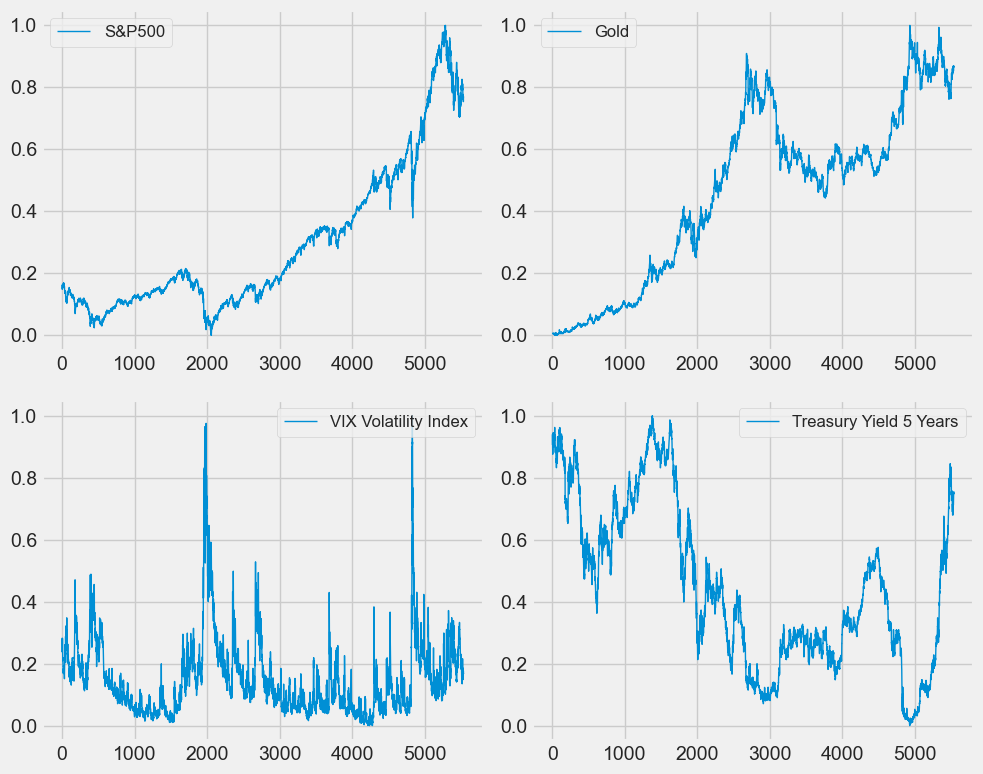

In [1]:
import sys
sys.path.insert(1, r"C:/Users/mihao/OneDrive - Univerza v Ljubljani/Doktorski_studij/Delo/Evolving transformer")
sys.path.insert(1, r"C:\Users\Miha\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\Evolving transformer")
from importlib import reload 
import data.dataclass as dataclass
reload(dataclass)

input_length = 128
output_length = 1
output_steps_ahead = 1
database = dataclass.StockData(input_length,output_length,output_steps_ahead)
database.display_data_norm()

#print(database.data_dropped)
print(database.data_norm)

#print(database.datasnp_dropped)
scalar = database.scalar

database.dataset_input
database.dataset_output


In [2]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class Stockdataset(Dataset):
    def __init__(self, data, input_length = 128, output_length = 1):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.seq_len = input_length
        self.out_len = output_length

    def __len__(self):
        return len(self.data)-(self.seq_len+self.out_len+1)

    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len+1: index+self.seq_len+self.out_len+1,0]
        
size_training = int(len(database.data_norm)*0.8)
size_test = len(database.data_norm) - size_training
data_train, data_test = database.data_norm[0:size_training,:], database.data_norm[size_training:len(database.data_norm),:]

print(data_train.shape)
print(data_test.shape)

train_dataset = Stockdataset(data_train, input_length, output_length)
test_dataset = Stockdataset(data_test, input_length, output_length)
whole_dataset = Stockdataset(database.data_norm, input_length, output_length)

print(test_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[1].shape)
print(whole_dataset.__getitem__(0)[0].shape)


(4431, 4)
(1108, 4)
torch.Size([128, 4])
torch.Size([1])
torch.Size([128, 4])


In [3]:
batch_size = 257
train_dataloader = DataLoader(train_dataset, batch_size, drop_last = True, shuffle=True) #drop_last = True ignores last batch is data is not divisable by batch_size
test_dataloader = DataLoader(test_dataset, batch_size, drop_last = True, shuffle=True)
whole_dataloader = DataLoader(whole_dataset, 1, drop_last = False)
whole_dataloader = DataLoader(train_dataset, 1, drop_last = False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [4]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv
import time
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

class EvolvingSystem(nn.Module):
    def __init__(self, input_dim, output_dim, cluster_dim, num_clusters,embed_dim,num_heads):
        super(EvolvingSystem, self).__init__()
        self.input_size = input_dim
        self.output_size = output_dim
        self.cluster_dim = cluster_dim
        self.num_clusters = num_clusters
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        #self.etta = torch.nn.Parameter(data=torch.ones(1), requires_grad=True)
        self.mu = torch.nn.Parameter(data = torch.rand(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.sigma_inv = torch.nn.Parameter(data=(torch.rand(self.num_clusters,self.cluster_dim, self.cluster_dim)  + 
            	torch.diag_embed(2*torch.ones(self.num_clusters,self.cluster_dim))), requires_grad=True)
        self.msa = nn.MultiheadAttention(self.embed_dim, self.num_heads)
        #self.sigma = torch.nn.Parameter(torch.matmul(self.sigma_inv, torch.transpose(self.sigma_inv, 2, 1)), requires_grad=True)
        #self.sigma_alpha = torch.nn.Parameter(data=torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.fc_ant = nn.Linear(input_length, self.cluster_dim) #self.cluster_dim
        #self.fc_con = nn.Linear(input_length, output_length) #output_length
        self.fc_con = nn.Linear(input_length, self.num_clusters) #output_length
        self.sm = torch.nn.Softmax(dim = 1)
        self.fc_emb = nn.Linear(input_length, 3*self.embed_dim) #output_length
        self.input_layer_norm = nn.LayerNorm(input_length)
        self.ant_norm = nn.LayerNorm(self.cluster_dim)
        #self.evol_drop_layer = nn.Dropout(p=0.5)

    def forward(self, x, u):
        #torch.Size([256, 128, 16]); IxBxH
        #self.x = x.flatten()
        x = x.reshape(batch_size, 1, input_length)
        
        #x = self.input_layer_norm(x)
        #self.x_emb = self.fc_emb(x)
        #query,key,value = self.x_emb.chunk(3, dim=-1)
        #self.x_att, _ = self.msa(query,key,x)
        #self.x_att = self.input_layer_norm(self.x_att)
        self.x_att = x
        
        self.x_ant = self.fc_ant(self.x_att)
        #self.x_ant  = self.ant_norm(self.x_ant)
        #self.x_ant = self.ant_norm(self.x_ant)
        
        x_con = x
        #self.x_ant = torch.cat((self.x_ant, u.reshape(batch_size,1,1)), dim = 2)

        d = torch.sub((self.mu), self.x_ant)
        dl = d.reshape(batch_size, self.num_clusters, 1, self.cluster_dim)
        
        #TEST OK -> self.mu-self.x_ant[0][0], d[0], dl[0]
        sigma_inv = torch.matmul((self.sigma_inv), torch.transpose((self.sigma_inv), 2, 1))
        #sigma_inv = self.sigma_inv
        
        d2_dS = torch.matmul(dl, sigma_inv)

        dr = d.reshape(batch_size, self.num_clusters, self.cluster_dim, 1)

        #d2 = torch.matmul(d2_dS, dr)
        d2 = torch.matmul(dl, dr)
        #d2 = torch.pow(d2, torch.pow(self.etta, 2))
        psi = self.sm(-d2).reshape(batch_size, 1, self.num_clusters)
        #psi = self.evol_drop_layer(psi)
        #TEST OK -> self.sm(-d2).reshape(batch_size,1,self.num_clusters)[0], self.sm(-d2)
        
        #x_con = x_con.repeat(1,self.num_clusters,1)
        y_con = self.fc_con(x_con) #.reshape(batch_size, -1, self.num_clusters) #.reshape(batch_size, output_length, self.num_clusters)
        
        #print(torch.sum(psi[0]))
        y = torch.matmul(psi, torch.transpose(y_con,-1,-2))
        
        #final_out = self.fc(out)
        return y

Parameter containing:
tensor([-0.0009,  0.0448,  0.0273,  0.0366,  0.0629,  0.0743, -0.0012,  0.0588,
         0.0428], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0621, -0.0691,  0.0868,  ...,  0.0536, -0.0713,  0.0261],
        [-0.0193, -0.0363, -0.0666,  ...,  0.0800,  0.0342, -0.0196],
        [-0.0496,  0.0581, -0.0637,  ..., -0.0158, -0.0746,  0.0537],
        ...,
        [ 0.0291,  0.0409, -0.0616,  ...,  0.0754, -0.0195,  0.0411],
        [ 0.0385, -0.0869,  0.0373,  ...,  0.0650,  0.0395, -0.0206],
        [-0.0711, -0.0047,  0.0602,  ...,  0.0872, -0.0501,  0.0121]],
       device='cuda:0', requires_grad=True)


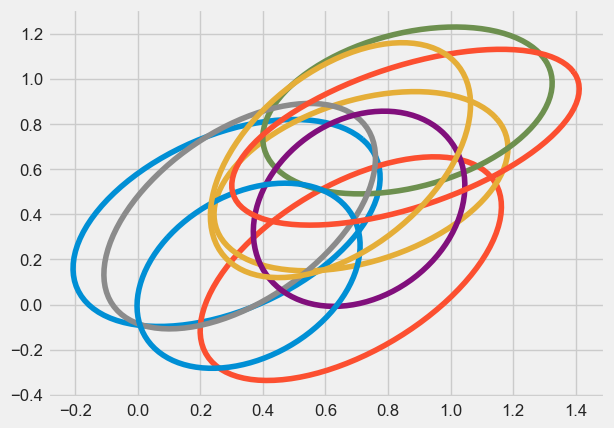

In [5]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size, num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.output_size = output_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.evolve = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters,embed_dim,num_heads)
        #self.fc = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters,hidden_size)

    def forward(self, x, hn, cn):
        out, (hn, cn) = self.lstm(x, (hn,cn))
        out = self.fc(out)
        final_out = self.evolve(out,x[-1,:,0])
        #final_out = self.fc(out)
        return final_out, hn, cn
    
    '''
    def predict(self, x):
        hn, cn = self.init()
        out = self.fc(out)
        final_out = self.evolve(out, x[-1,:,0])
        #final_out = self.fc(out)
        return final_out, hn, cn 
    '''
    
    def init(self):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) #zakaj je batch_size tako?
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return h0,c0

embed_dim = input_length
num_heads = input_length//8
cluster_dim = 2
num_clusters = 9
input_dim = 4
output_dim = 1
hidden_size = input_length//32
num_layers = 1
model = Lstm_model(input_dim, output_dim, hidden_size, num_layers).to(device)

sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())[:,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()[:,0:2]
ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1]) 
display.display(pl.gcf())   
display.clear_output(wait=True)
time.sleep(0.1)

print(model.evolve.fc_con.bias)
print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)



In [6]:
def train(dataloader):
    hn, cn = model.init()
    model.train()
    loss_sum = 0
    x_ant = np.empty((0,1,cluster_dim))     
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        out, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
        #out, hn, cn = model(x, hn, cn)
        loss = loss_fun(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_sum = loss_sum + loss.item()
        x_ant = np.append(x_ant, model.evolve.x_ant.detach().cpu().numpy(),axis=0)
        hn = hn.detach() #detach hn is not a parameters and does not need to be updated!!!
        cn = cn.detach()
        '''
        model.evolve.mu.grad
        model.evolve.sigma_inv.grad
        model.evolve.msa.in_proj_weight.grad
        model.evolve.msa.in_proj_bias.grad
        model.evolve.msa.out_proj.weight.grad
        model.evolve.msa.out_proj.bias.grad
        model.evolve.fc_ant.weight.grad
        model.evolve.fc_ant.bias.grad
        model.evolve.fc_con.weight.grad
        model.evolve.fc_con.bias.grad
        model.evolve.fc_emb.weight.grad
        model.evolve.fc_emb.bias.grad
        model.evolve.input_layer_norm.weight.grad
        model.evolve.input_layer_norm.bias.grad
        model.evolve.ant_norm.weight.grad
        model.evolve.ant_norm.bias.grad
        '''
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch == len(dataloader) -1:
            print(f"Train loss: {loss_sum:>7f}")
    return loss_sum, x_ant

In [7]:
def test(dataloader):
    hn, cn = model.init()
    loss_sum = 0
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        out, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
        loss = loss_fun(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_sum = loss_sum + loss.item()
        if batch == len(dataloader) -1:
            #loss = loss.item()
            print(f"Test loss: {loss_sum:>7f}")   
    return loss_sum
            

In [8]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

lstm.weight_ih_l0 tensor([[ 0.3472,  0.1259, -0.2403, -0.0806],
        [ 0.2051,  0.3123, -0.3266, -0.0118],
        [-0.4588, -0.0696, -0.0156, -0.1254],
        [ 0.2802, -0.2997,  0.4162, -0.4556],
        [-0.1274, -0.3029, -0.3492,  0.3442],
        [ 0.4689,  0.1987, -0.1316,  0.3600],
        [-0.4469, -0.1100, -0.2873,  0.0427],
        [-0.2776, -0.4154,  0.3814,  0.1029],
        [-0.1768, -0.0313, -0.3228,  0.1507],
        [-0.2729, -0.4551,  0.3238, -0.4358],
        [-0.2075,  0.0529, -0.1150, -0.0396],
        [ 0.0277,  0.3869, -0.2935,  0.3107],
        [-0.1997,  0.2251,  0.3294, -0.3188],
        [ 0.3524, -0.2991, -0.0278, -0.0369],
        [ 0.2053,  0.3214, -0.1590,  0.4366],
        [-0.1473,  0.2133,  0.0436,  0.1892]], device='cuda:0')
lstm.weight_hh_l0 tensor([[ 0.3439, -0.1147,  0.2428,  0.0196],
        [ 0.3017,  0.3847, -0.2057,  0.4531],
        [-0.1838, -0.1561,  0.4819, -0.0815],
        [ 0.4748,  0.4017, -0.1522,  0.2238],
        [ 0.3236, -0.4508,

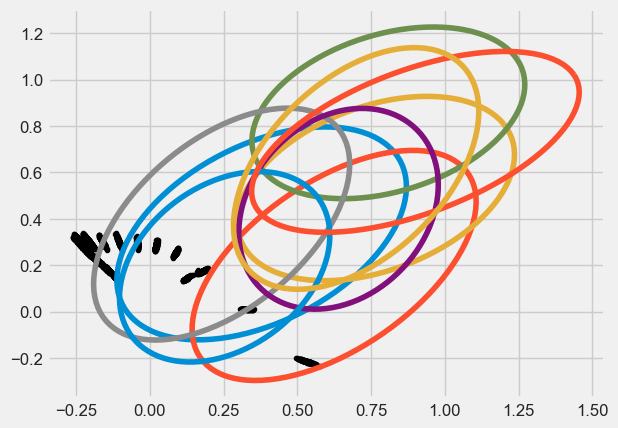

<Figure size 640x480 with 0 Axes>

lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
fc.weight
fc.bias
evolve.mu
evolve.sigma_inv
evolve.msa.in_proj_weight
evolve.msa.in_proj_bias
evolve.msa.out_proj.weight
evolve.msa.out_proj.bias
evolve.fc_ant.weight
evolve.fc_ant.bias
evolve.fc_con.weight
evolve.fc_con.bias
evolve.fc_emb.weight
evolve.fc_emb.bias
evolve.input_layer_norm.weight
evolve.input_layer_norm.bias
evolve.ant_norm.weight
evolve.ant_norm.bias
Epoch 0


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

<Figure size 640x480 with 0 Axes>

In [9]:

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

batch_size = 257
best_model = 1
loss_fun = nn.MSELoss()
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', init_params="kmeans")

train_iterations = 50
for i in range(train_iterations):
    lr = 1e-2
    
    for p in model.parameters():
        p.requires_grad = True
    '''
    for name, param  in model.named_parameters():
        print(name)
        if "evolve.fc_con.weight" == name:
            param.requires_grad = False
        if "evolve.fc_con.bias" == name:
            param.requires_grad = False
        if "evolve.fc_emb.weight" == name:
            param.requires_grad = False
        if "evolve.fc_emb.bias" == name:
            param.requires_grad = False
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    epochs = 1
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        loss_train, x_ant_train = train(train_dataloader)
        loss_test = test(test_dataloader)
        state_dict = model.state_dict()
        if (best_model > loss_train):
            best_model = loss_train
            torch.save(state_dict, "model_evolve.pt")
            
        #state_dict['model.evolve.mu'] = torch.from_numpy(gmm.means_)
        #state_dict['model.evolve.sigma_inv'] = torch.from_numpy(inv(gmm.covariances_))
        #model.load_state_dict(state_dict)
        #sns.heatmap(model.x_ant.detach().cpu().numpy()[0,:,:], vmin=0, vmax=1.0, cmap="OrRd")
        #plt.plot(model.evolve.x_ant.detach().cpu().numpy()[0,0,:])
        
        if True:
            display.clear_output(wait=True) 
            sigma_inv = model.evolve.sigma_inv
            sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
            sigma = inv(sigma_inv.detach().cpu().numpy())
            nc_plot = num_clusters
            sigma = sigma[0:nc_plot,0:2,0:2]
            mu = model.evolve.mu.detach().cpu().numpy()
            mu = mu[0:nc_plot,0:2]
            ellipse = compute_ellipse.Ellipse(sigma,mu,1)
            ellipse_points = ellipse.confidence_ellipse()
            ellipse_points = np.einsum('ijk->jik', ellipse_points)
            plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.k')
            plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
            plt.show()  
            display.display(pl.gcf())   
    '''
    gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', init_params="kmeans")
    #gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sigma)).transpose((0, 2, 1))
    gmm.fit(x_ant_train[:,0,:])
    mu = gmm.means_
    sigma_inv = (gmm.covariances_)
    u, s, v   = np.linalg.svd(sigma_inv, full_matrices=True)
    s_sqrt = torch.diag_embed(torch.from_numpy(np.sqrt(s))).numpy()
    sigma_inv = inv(np.matmul(s_sqrt, v))
    
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'evolve.mu' == name:
                param.copy_(torch.from_numpy(mu))
            if 'evolve.sigma_inv' == name:
                param.copy_(torch.from_numpy(sigma_inv))
    

    
    if True:
        display.clear_output(wait=True) 
        sigma_inv = model.evolve.sigma_inv
        sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
        sigma = inv(sigma_inv.detach().cpu().numpy())
        nc_plot = num_clusters
        sigma = sigma[0:nc_plot,0:2,0:2]
        mu = model.evolve.mu.detach().cpu().numpy()
        mu = mu[0:nc_plot,0:2]
        ellipse = compute_ellipse.Ellipse(sigma,mu,1)
        ellipse_points = ellipse.confidence_ellipse()
        ellipse_points = np.einsum('ijk->jik', ellipse_points)
        plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.k')
        plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
        plt.show()  
        display.display(pl.gcf())  
         
    '''
    for p in model.parameters():
        p.requires_grad = False
    for name, param  in model.named_parameters():
        print(name)
        if "model.evolve.mu" == name:
            param.requires_grad = True
    
    lr = 1e1
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    epochs = 10
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        loss_train, x_ant_train = train(train_dataloader)
        loss_test = test(test_dataloader)
        state_dict = model.state_dict()
        if (best_model > loss_train):
            best_model = loss_train
            torch.save(state_dict, "model_evolve.pt")
            
        #state_dict['model.evolve.mu'] = torch.from_numpy(gmm.means_)
        #state_dict['model.evolve.sigma_inv'] = torch.from_numpy(inv(gmm.covariances_))
        #model.load_state_dict(state_dict)
        #sns.heatmap(model.x_ant.detach().cpu().numpy()[0,:,:], vmin=0, vmax=1.0, cmap="OrRd")
        #plt.plot(model.evolve.x_ant.detach().cpu().numpy()[0,0,:])
        if True:
            display.clear_output(wait=True) 
            sigma_inv = model.evolve.sigma_inv
            sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
            sigma = inv(sigma_inv.detach().cpu().numpy())
            nc_plot = num_clusters
            sigma = sigma[0:nc_plot,0:2,0:2]
            mu = model.evolve.mu.detach().cpu().numpy()
            mu = mu[0:nc_plot,0:2]
            ellipse = compute_ellipse.Ellipse(sigma,mu,1)
            ellipse_points = ellipse.confidence_ellipse()
            ellipse_points = np.einsum('ijk->jik', ellipse_points)
            plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.k')
            plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
            plt.show()  
            display.display(pl.gcf())   
      

            


In [ ]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            x = x.view(input_length, batch_size, input_dim)
            pred = model(x, hn, cn)
            pred = pred.view(batch_size, -1,1)
            pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=2)
            pred = scalar.inverse_transform(pred)[:,0]
            y = np.repeat(y.detach().cpu().numpy(),input_dim,axis=1)
            y = scalar.inverse_transform(y)[:,0]
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)

        return math.sqrt(mean_squared_error(y_arr,pred_arr))



In [ ]:
from torchsummary import summary

print(model.evolve.fc_con.bias)
print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)

#summary(model,[(input_length, 1, input_dim),(num_layers, 1, hidden_size),(num_layers, 1, hidden_size)])

model.load_state_dict(torch.load("model_evolve.pt"))
model.eval()


In [ ]:

#print(f"Train MSE loss {calculate_metrics(train_dataloader)}")
#print(f"Test MSE loss {calculate_metrics(test_dataloader)}")

In [ ]:
def simulate(dataloader):
    pred_arr = []
    y_arr = []
    x_ant = np.empty((0,1,cluster_dim))
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            #pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)#[0]
            #pred = model.predict(x.reshape(input_length, batch_size, input_dim))[0]
            pred,hn,cn = model(x.reshape(input_length, 1, input_dim), hn, cn)
            pred = pred.detach().cpu().numpy().reshape(1,-1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy()
            #plt.plot(np.linspace(1,input_length, input_length), x[0,:,0].detach().cpu().numpy())
            #plt.plot(np.linspace(input_length+1,input_length+output_length, 100),y[0,:].reshape(-1))
            #plt.plot(np.linspace(input_length+1,input_length+output_length, 100),pred[0,:].reshape(-1))
            #plt.show()
            pred_arr = pred_arr + list(pred[0,-1].reshape(-1))
            y_arr = y_arr + list(y[0,-1].reshape(-1))
            x_ant = np.append(x_ant, model.evolve.x_ant.detach().cpu().numpy(),axis=0)
            
    return pred_arr, y_arr, x_ant
    
batch_size = 1
whole_pred_arr, whole_y_arr, x_ant  = simulate(whole_dataloader)



In [ ]:
import matplotlib.pyplot as plt
fig1, axes1 = plt.subplots(figsize = (5, 3))
axes1.plot(whole_y_arr, linewidth=0.5)
axes1.plot(whole_pred_arr, linewidth=0.5)
fig1.savefig("model_evolve.pdf")

In [ ]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv
'''
sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(torch.log(sigma_inv), torch.transpose(torch.log(sigma_inv), 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())
nc_plot = num_clusters
sigma = sigma[0:nc_plot,0:2,0:2]
mu = torch.log(model.evolve.mu).detach().cpu().numpy()
mu = mu[0:nc_plot,0:2]
ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.k')
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
plt.show()
'''   
      
sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())

nc_plot = num_clusters
sigma = sigma[0:nc_plot,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()
mu = mu[0:nc_plot,0:2]

ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(x_ant[:,0,0],x_ant[:,0,1],'.k')
plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.m')
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
plt.show()  


In [ ]:
history -g


In [ ]:
'''
%matplotlib inline
import time
import pylab as pl
from IPython import display
#fig2, axes2 = plt.subplots(figsize = (5, 3), linewidth=0.5)
#line1, = axes2.plot(np.zeros(output_length))
#line2, = axes2.plot(np.zeros(output_length))

import matplotlib.pyplot as plt
import time

def simulate(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn) #[0]
            pred = pred.detach().cpu().numpy().reshape(-1,1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy().reshape(-1,1)
            pred_arr = np.append( pred_arr, pred)
            y_arr = np.append(y_arr, y)

            
            #axes2.cla()  
            #line1.set_ydata(pred_arr)
            #line2.set_ydata(y_arr)
            plt.plot(pred_arr,'b')
            plt.plot(y_arr,'r')
            #fig2.tight_layout()
            #fig2.show()

            display.display(pl.gcf())   
            display.clear_output(wait=True)
            time.sleep(0.1)
            
    return pred_arr, y_arr

batch_size = 1
whole_pred_arr, whole_y_arr = simulate(whole_dataloader)
'''